In [1]:
import numpy as np
import pandas as pd
import gzip,pickle,os
from tqdm import tqdm_notebook as tq
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

### Some global params
year_range = range(1991,2016)

In [29]:
# here we specify the d2v folder, as well as which d2v parameters we're looking at
d2v_dir = 'P:/Projects/WoS/wos-text-dynamics-data/d2v-wos/'
param = '100-5-5-0.001-None'

In [30]:
# print out the result folderswithin the relevant  folder so we can pick the one of interest
print([f for f in os.listdir('{}{}'.format(d2v_dir,param)) if os.path.isdir('{}{}/{}'.format(d2v_dir,param,f))])

['100-5-5-0.001-None_global-norm_992283_1000_100_100000_None']


In [31]:
# now we select the result folder of interest
result_params = '100-5-5-0.001-None_global-norm_992283_1000_100_100000_None'
result_dir = '{}{}/{}/'.format(d2v_dir,param,result_params)

,idx,dists,neighbor_counts
0,5935396,"[0.322056561293, 0.323556474059, 0.31989718899...","[35, 53, 42, 43, 47, 42, 51, 80, 43, 58, 58, 4..."
1,5635372,"[0.328837867162, 0.326223281662, 0.32840947115...","[51, 62, 61, 63, 51, 54, 53, 66, 57, 47, 43, 4..."
2,5972899,"[0.230598558701, 0.23368575629, 0.230531675362...","[13, 21, 19, 24, 38, 37, 68, 97, 101, 92, 96, ..."
3,6066440,"[0.126167991961, 0.125130725291, 0.12309294773...","[22, 15, 10, 4, 2, 2, 2, 6, 11, 19, 17, 24, 31..."
4,5947051,"[0.129690233728, 0.131457217099, 0.12908399370...","[17, 12, 15, 11, 10, 6, 4, 7, 15, 23, 28, 32, ..."


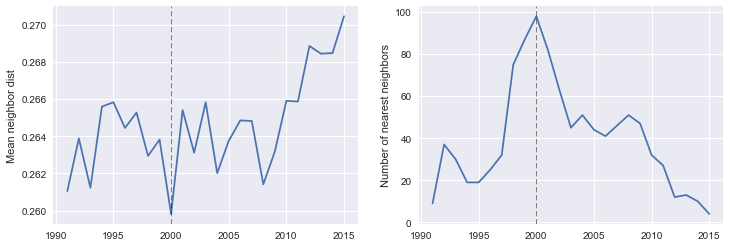

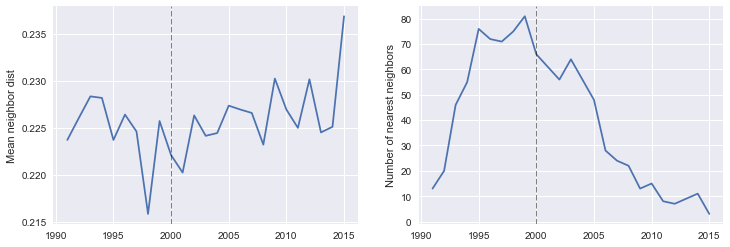

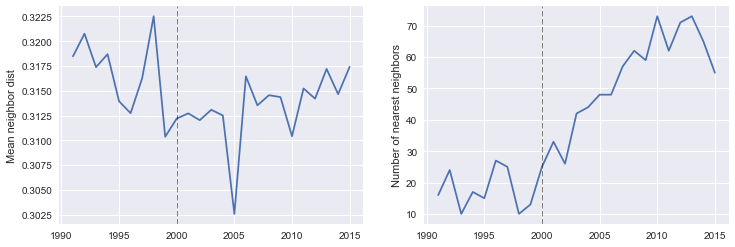

In [32]:
# Just an example of handling a results file and plotting the relevant results.
# This just shows the result data fro three randomly selected papers

# specify year
year = 2000
# load dataframe
df = pd.read_table(result_dir+'results_{}'.format(year),header=None,names=['idx','dists','neighbor_counts'])
# convert strings to arrays
df['dists'] = df['dists'].apply(lambda x: np.array(x.split(','),dtype=float))
df['neighbor_counts'] = df['neighbor_counts'].apply(lambda x: np.array(x.split(','),dtype=int))
display(df.head())

# for a particular paper we can look at both its mean distance to neighbors each year,
# and the frequency distribution of neighbors over time.
# We draw a vertical line to indicate the publication year of the target paper
# Here are a few examples:
for random_abstract in np.random.randint(len(df),size=3):
    fig,axes = plt.subplots(1,2,figsize=(12,4))

    ax = axes[0]
    ax.plot(year_range,df.iloc[random_abstract].dists)
    ax.set_ylabel('Mean neighbor dist')
    ax.axvline(year,c='k',ls='--',lw=0.5)

    ax = axes[1]
    ax.plot(year_range,df.iloc[random_abstract].neighbor_counts)
    ax.set_ylabel('Number of nearest neighbors')
    ax.axvline(year,c='k',ls='--',lw=0.5)

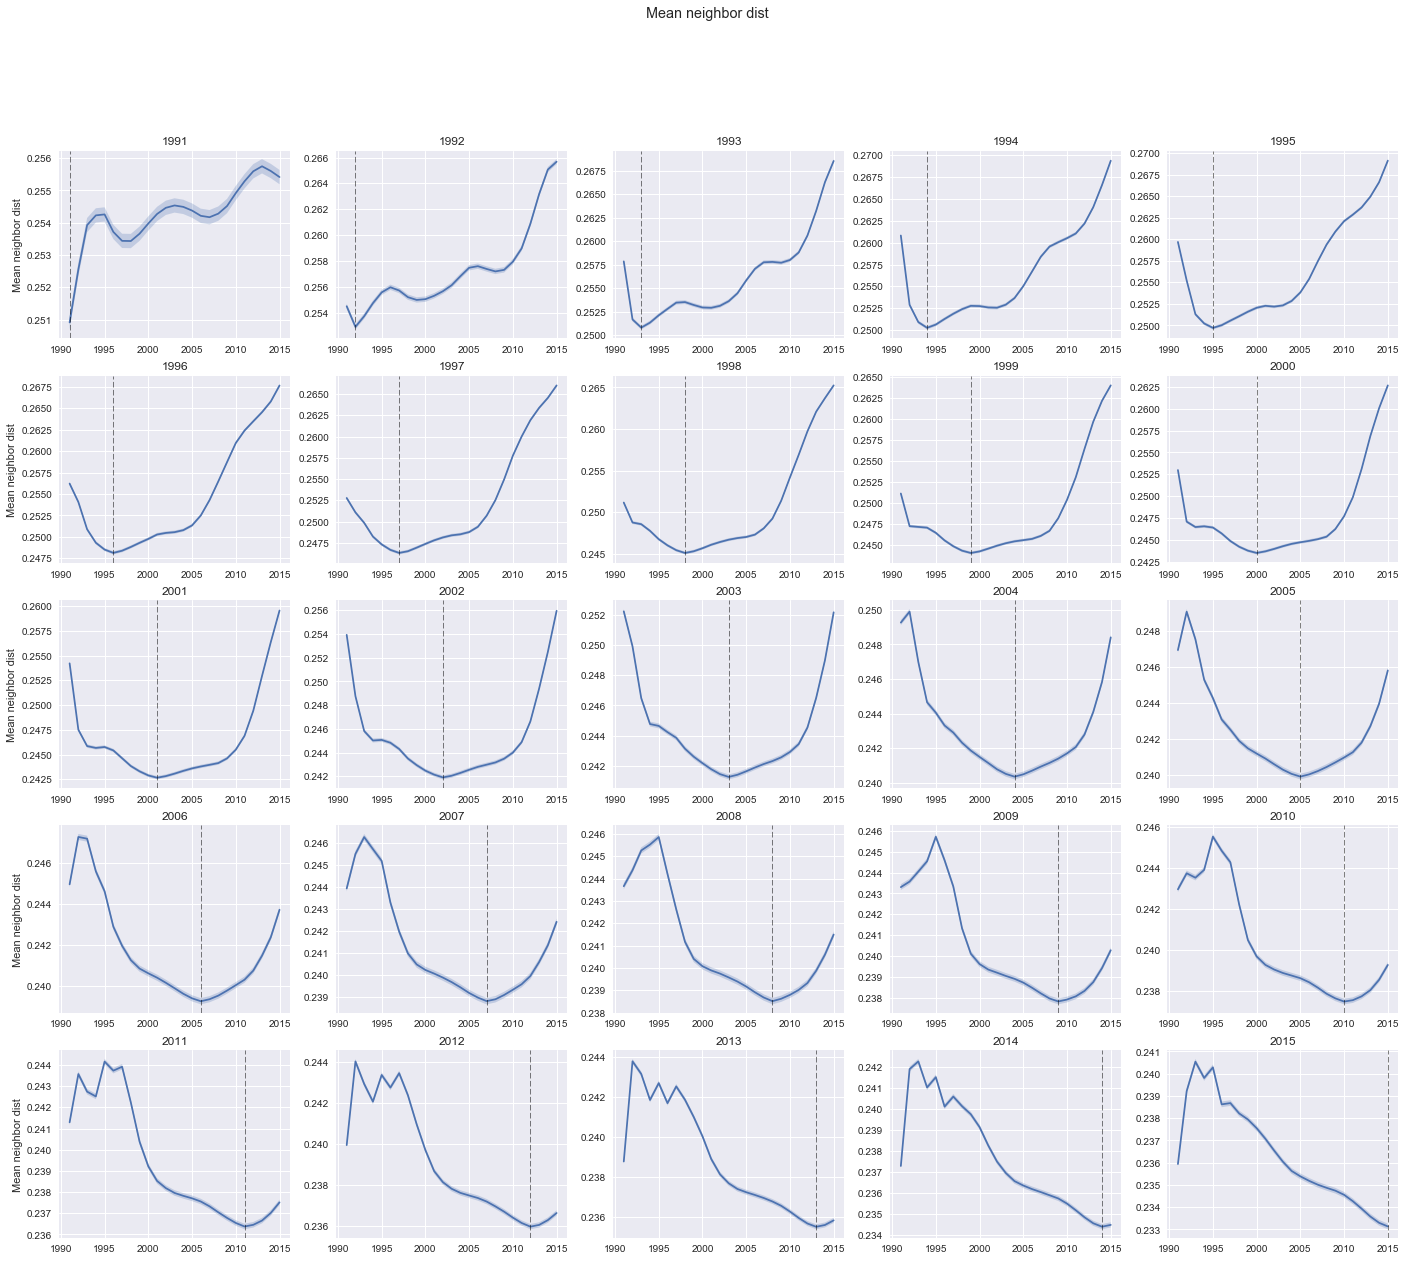

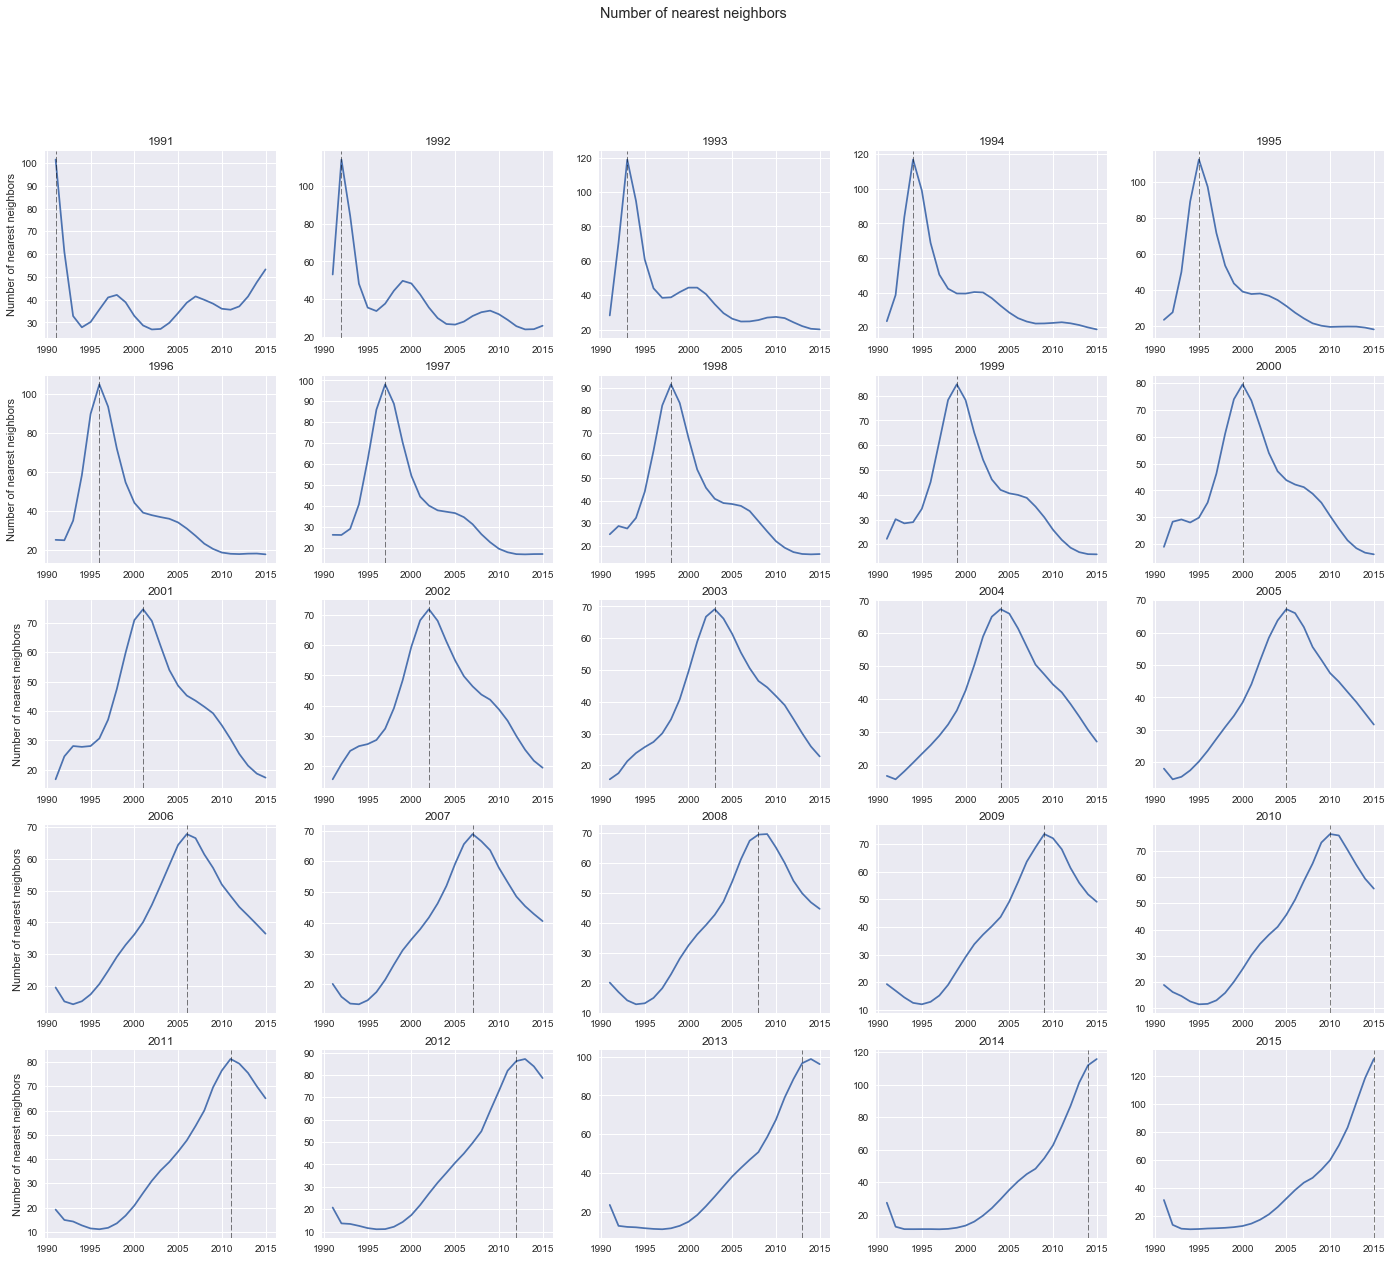

In [33]:
# Now let's extend this to plot the same results, averaged across all papers published each year.
# In other word,s we're plotting the same curves as above, averaged across all papers published
# each year. Error bars are confidence intervals on the ean 

fig_dict = {'dists':plt.subplots(5,5,figsize=(24,20)),
            'neighbor_counts':plt.subplots(5,5,figsize=(24,20))}
ylabels = {'dists':'Mean neighbor dist','neighbor_counts':'Number of nearest neighbors'}
    
for i,year in enumerate(range(1991,2016)):
    df = pd.read_table(result_dir+'results_{}'.format(year),header=None,names=['idx','dists','neighbor_counts'])
    df['dists'] = df['dists'].apply(lambda x: np.array(x.split(','),dtype=float))
    df['neighbor_counts'] = df['neighbor_counts'].apply(lambda x: np.array(x.split(','),dtype=int))
    arrs = {}
    arrs['dists'] = np.array([row for row in df.dists.values])
    arrs['neighbor_counts'] = np.array([row for row in df.neighbor_counts.values])
    for measure in fig_dict:
        ax = fig_dict[measure][1].flat[i]
        arr = arrs[measure]
        m = np.nanmean(arr,0)
        ax.plot(m)
        ci = 1.96*(np.nanstd(arr,0)/np.sqrt(len(arr)))
        ax.fill_between(range(25),m-ci,m+ci,alpha=0.25)
        ax.set_xticks(np.arange(-1,25,5))
        ax.set_xticklabels(np.arange(1990,2016,5))
        ax.axvline(i,c='k',ls='--',lw=0.5)
        ax.set_title(year)
        if i%5==0:
            ax.set_ylabel(ylabels[measure])
for k in fig_dict:
    fig_dict[k][0].suptitle(ylabels[k])




In [34]:
# Now we want to repeat that analysis, but comparing hit vs. non-hit papers
# (for now, we'll just call hits the the top 10th percentile of papers published in a given year)

# we'll have to do some setup first:

#build a didct of idx-> uid mappings
uid_dict = {}
idx=0
for year in tq(range(1991,2016)):
    for line in gzip.open('P:/Projects/WoS/wos-text-dynamics-data/d2v-wos/uid_indices/{}.txt.gz'.format(year)):
        uid = line.decode('utf8').strip()
        uid_dict[idx] = uid
        idx+=1


1991->67.0 1992->67.0 1993->68.0 1994->67.0 1995->68.0 1996->68.0 1997->69.0 1998->69.0 1999->70.0 2000->72.0 2001->69.0 2002->68.0 2003->66.0 2004->62.0 2005->59.0 2006->53.0 2007->49.0 2008->43.0 2009->38.0 2010->33.0 2011->26.0 2012->20.0 2013->14.0 2014->8.0 2015->4.0 

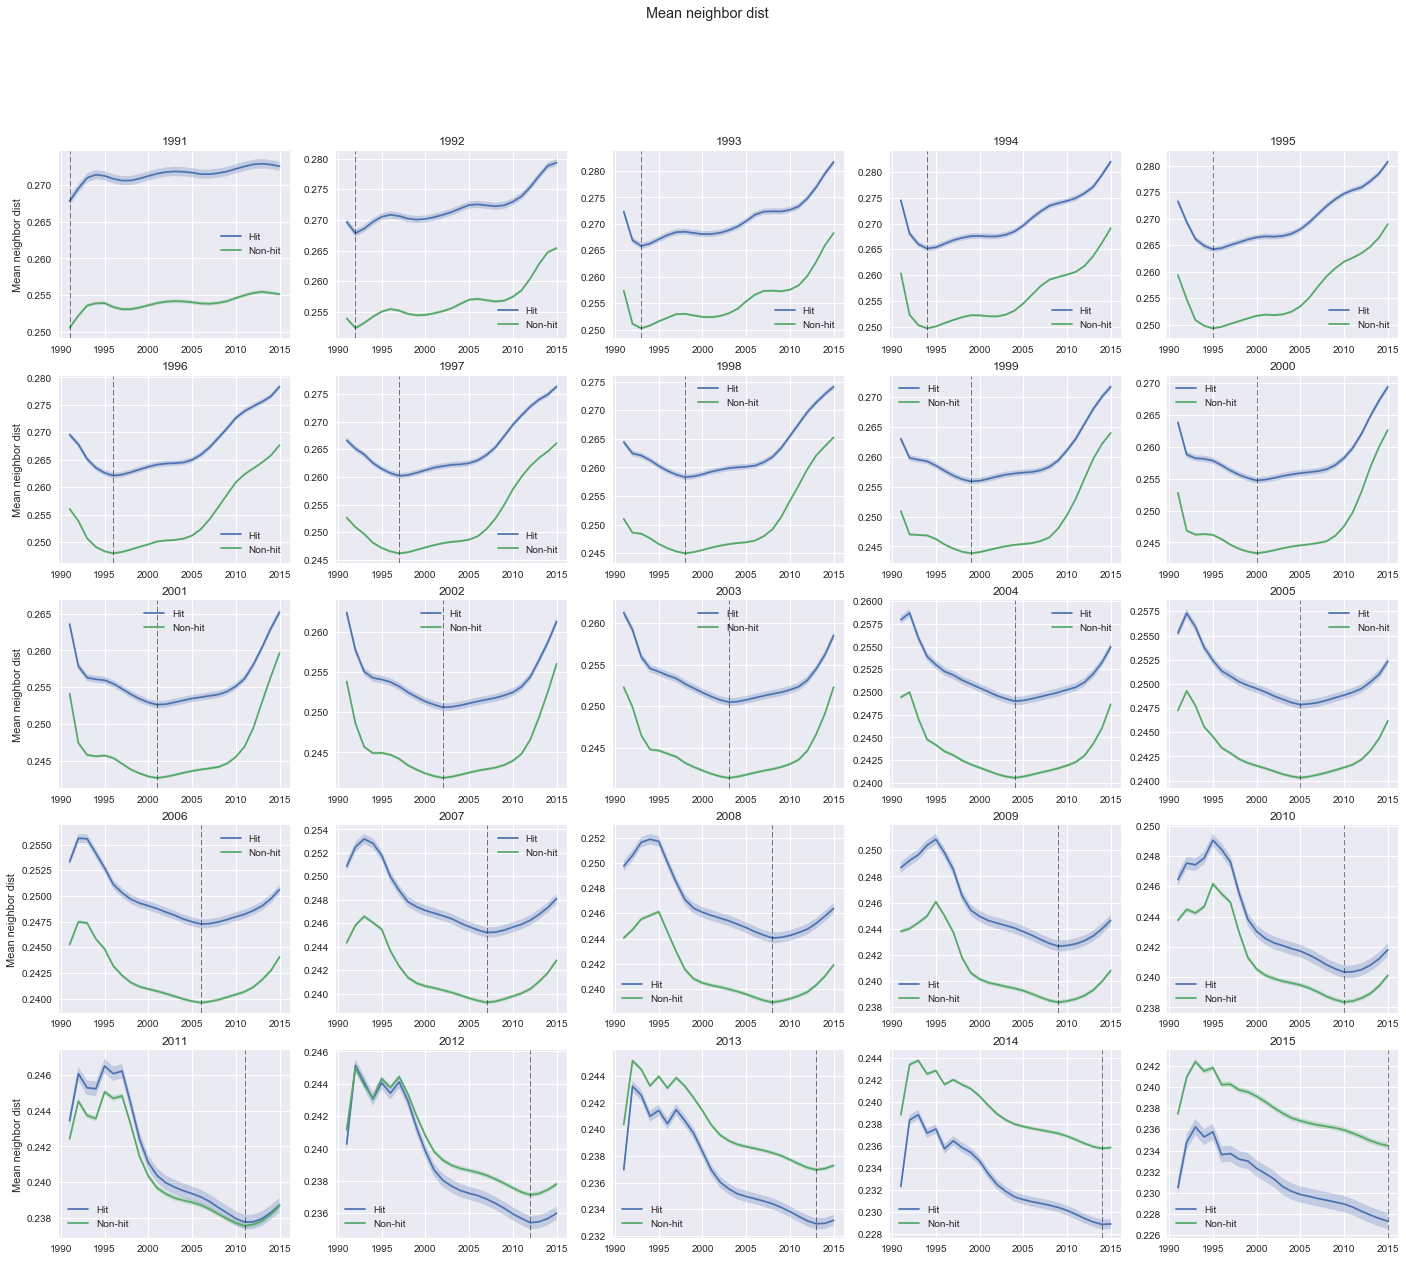

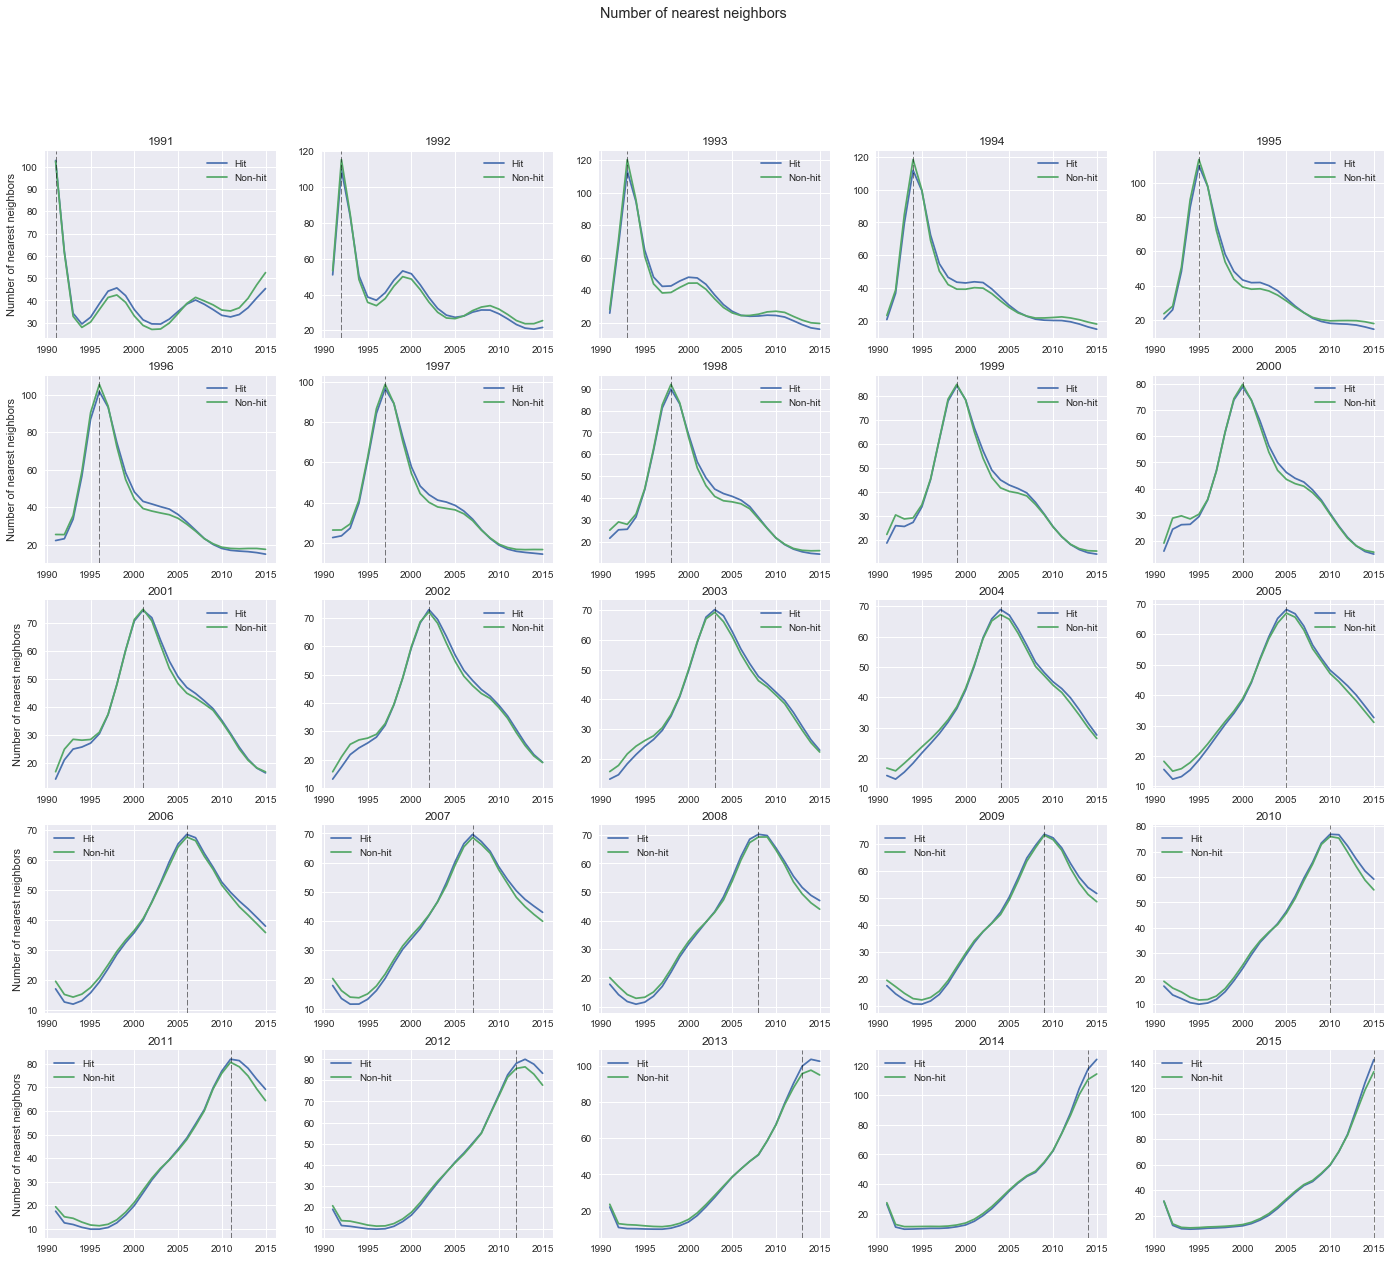

In [35]:
# and here we generate the plots:


fig_dict = {'dists':plt.subplots(5,5,figsize=(24,20)),
            'neighbor_counts':plt.subplots(5,5,figsize=(24,20))}
ylabels = {'dists':'Mean neighbor dist','neighbor_counts':'Number of nearest neighbors'}
    
for i,year in enumerate(range(1991,2016)):
    df = pd.read_table(result_dir+'results_{}'.format(year),header=None,names=['idx','dists','neighbor_counts'])
    df['dists'] = df['dists'].apply(lambda x: np.array(x.split(','),dtype=float))
    df['neighbor_counts'] = df['neighbor_counts'].apply(lambda x: np.array(x.split(','),dtype=int))
    
    # join the dataframe with the citation data
    df['uid'] = [uid_dict.get(idx) for idx in df.idx]
    citations = pd.read_table('P:/Projects/WoS/parsed/citations_total/{}.txt.gz'.format(year),header=None,names=['uid','citations'])
    citations['idx'] = [uid_dict.get(uid) for uid in citations.uid]
    merged = citations.merge(df,on='uid')

    # define hits
    thresh = merged.citations.quantile(.9)
    print("{}->{}".format(year,thresh),end=' ')
    merged['hit'] =(merged.citations>=thresh).astype(int)
    
    arrs_hit = {}
    arrs_nonhit = {}
    arrs_hit['dists'] = np.array([row for row in merged[merged['hit']==1].dists.values])
    arrs_hit['neighbor_counts'] = np.array([row for row in merged[merged['hit']==1].neighbor_counts.values])
    arrs_nonhit['dists'] = np.array([row for row in merged[merged['hit']==0].dists.values])
    arrs_nonhit['neighbor_counts'] = np.array([row for row in merged[merged['hit']==0].neighbor_counts.values])
    
    for measure in fig_dict:
        ax = fig_dict[measure][1].flat[i]
        
        for a,label in zip((arrs_hit,arrs_nonhit),('Hit','Non-hit')):
            arr = a[measure]        
            m = np.nanmean(arr,0)
            ax.plot(m,label=label)
            ci = 1.96*(np.nanstd(arr,0)/np.sqrt(len(arr)))
            ax.fill_between(range(25),m-ci,m+ci,alpha=0.25)
        
        ax.legend()
        ax.set_xticks(np.arange(-1,25,5))
        ax.set_xticklabels(np.arange(1990,2016,5))
        ax.axvline(i,c='k',ls='--',lw=0.5)
        ax.set_title(year)
        if i%5==0:
            ax.set_ylabel(ylabels[measure])
for k in fig_dict:
    fig_dict[k][0].suptitle(ylabels[k])


